In [1]:
import torch
import torchvision
import itertools
import shap
import numpy as np
import scipy.special
import time
import warnings
from skimage.segmentation import slic, mark_boundaries
from PIL import Image
import matplotlib.pyplot as plt


import test

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


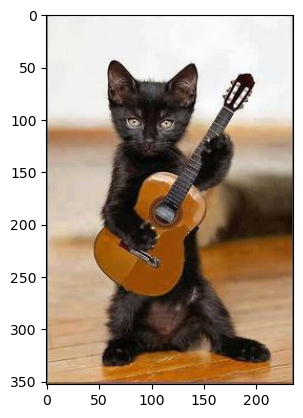

In [2]:
img = Image.open('images/cat_guitar.jpg')
plt.imshow(img)

(353, 236, 3)
(353, 236)


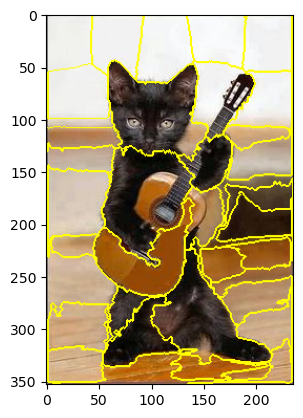

In [3]:
img_tensor = torchvision.transforms.functional.pil_to_tensor(img)
img_array = np.array(img)
img_array2 = np.tile(img, reps=(2,1,1,1))
a = slic(img_array, n_segments=50, compactness=10, start_label=0)

print(img_array.shape)
print(a.shape)

plt.imshow(mark_boundaries(img_array, a))

(74, 353, 236, 3)


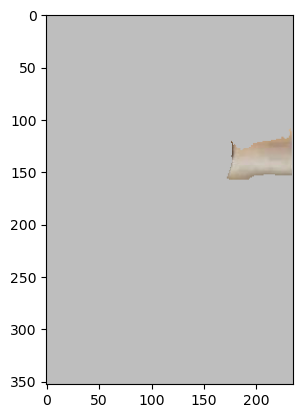

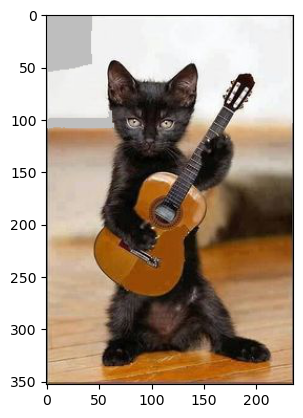

In [4]:
segments, masks = test.slic_segmenter(img_array, nbr_segments=50, compactness=10)

M = np.unique(segments).shape[0]
samples = test.shap_sampler(M, sample_size=M*2+2)
ciu_samples = test.naive_ciu_sampler(M,inverse=False)

perturbed_image, samples = test.single_color_pertuber(img_array, masks, samples, np.array((190,190,190)))
ciu_perturbed_image, ciu_samples = test.single_color_pertuber(img_array, masks, ciu_samples, np.array((190,190,190)))

print(perturbed_image.shape)
plt.figure()
plt.imshow(perturbed_image[14])
plt.figure()
plt.imshow(perturbed_image[73])



tensor(546)
tensor([546, 384, 402, 714, 285, 223, 284, 356, 420, 361, 358, 378, 357, 359,
        761, 224, 280, 199, 380, 370, 722, 362, 281, 235, 261, 650, 676, 249,
        674, 377, 851, 593, 746, 227, 889, 673, 194, 282, 252, 174, 187, 186,
        783, 367, 465, 268, 605, 383, 769, 333, 278, 233, 438, 633, 275, 198,
        205, 369, 925, 151, 193, 388, 941, 796, 584, 845, 776, 197, 600, 279,
        309, 615, 265, 287, 481, 826, 283, 373, 700, 203, 368, 335, 295, 487,
        683, 728, 535, 374, 917, 387, 759, 518, 590, 662, 784, 371, 626, 256,
        196, 259, 451, 552, 379, 185, 515, 409, 621, 731, 375, 244, 813, 286,
        290, 332, 782, 517, 737, 512, 793, 699, 491, 623, 844, 795, 220, 855,
        772, 861, 412, 677, 262, 742, 680, 439, 530, 334, 998, 942, 937, 613,
        455, 401, 543, 225, 664, 691, 189, 192, 508, 818, 686, 953, 226, 321,
        214, 846, 622, 852, 754, 486, 940, 277, 945, 916, 892, 635, 473, 381,
        553, 432, 740, 681,  93, 106, 273, 319, 260,

divide by zero encountered in divide


NameError: name 'riplt' is not defined

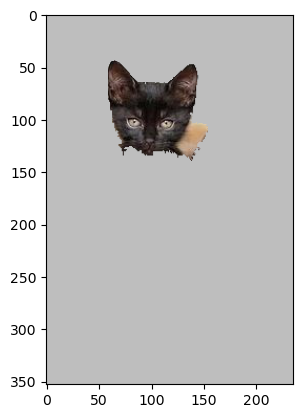

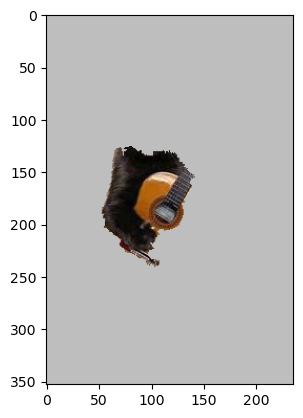

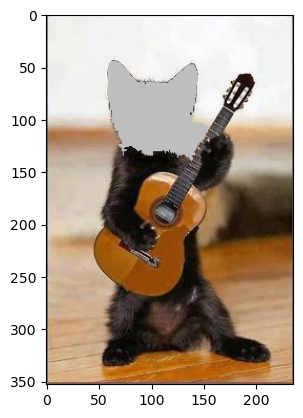

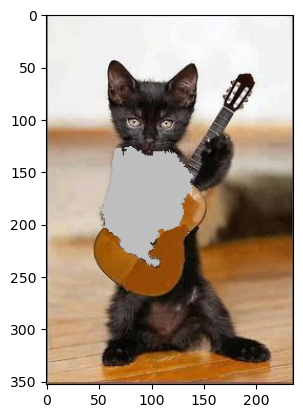

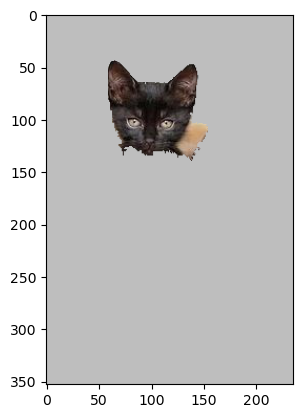

<Figure size 640x480 with 0 Axes>

In [5]:
alexnet = torchvision.models.resnet50(weights='IMAGENET1K_V1')
alexnet.eval()


from torchvision.transforms import v2

transforms = v2.Compose([
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    v2.Resize((224,224))
])

x = transforms(torch.from_numpy(perturbed_image/255).permute((0,3,1,2))).float()
ciu_x = transforms(torch.from_numpy(ciu_perturbed_image/255).permute((0,3,1,2))).float()

y = alexnet(x)
ciu_y = alexnet(ciu_x)

idx = y[1].argmax()
print(idx)

sorted, indices = y[1].sort(descending=True)
print(indices)

y = y.detach().numpy()
ciu_y = ciu_y.detach().numpy()

cat_idx = 281
guitar_idx = 402


cat_ys = y[:,cat_idx]
guitar_ys = y[:,guitar_idx]

print(ciu_y[:,cat_idx])

ciu_cat_ys = ciu_y[:,cat_idx]
ciu_guitar_ys = ciu_y[:,guitar_idx]




cat_shaps = test.shap_values(cat_ys, samples)
guitar_shaps = test.shap_values(guitar_ys,  samples)
 
cat_ciu = test.original_ciu_values(ciu_cat_ys, ciu_samples, inverse=False)
guitar_ciu = test.original_ciu_values(ciu_guitar_ys, ciu_samples, inverse=False)

cat_rise = test.rise_values(cat_ys, samples)
guitar_rise = test.rise_values(guitar_ys,  samples)

print(ciu_samples)

print(cat_shaps[0])
print(guitar_shaps[0])
print(np.argmin(ciu_cat_ys), np.min(ciu_cat_ys), np.argmax(ciu_cat_ys), np.max(ciu_cat_ys))
print(cat_ciu)
plt.imshow(perturbed_image[np.argmax(cat_shaps[0][:-1])+2])
plt.figure()
plt.imshow(perturbed_image[np.argmax(guitar_shaps[0][:-1])+2])
plt.figure()
plt.imshow(ciu_perturbed_image[np.argmax(cat_shaps[0][:-1])])
plt.figure()
plt.imshow(ciu_perturbed_image[np.argmax(guitar_shaps[0][:-1])])
plt.figure()
plt.imshow(perturbed_image[np.argmax(cat_rise)+2])
plt.figure()
plt.imshow(perturbed_image[np.argmax(guitar_rise)+2])
plt.figure()
plt.imshow(ciu_perturbed_image[np.argmax(cat_ciu)])
plt.figure()
plt.imshow(ciu_perturbed_image[np.argmax(guitar_ciu)])
#plt.figure()
#plt.imshow(ciu_perturbed_image[np.argwhere(np.max(cat_ciu) ==cat_ciu)[0,0]])
#plt.figure()
#plt.imshow(ciu_perturbed_image[np.argwhere(np.max(guitar_ciu) ==guitar_ciu)[1,0]])


